# Content-based Hybrid Feature Selection (RF)

In [1]:
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import filter_feature_selection
import scipy.stats as stats

The first stage of this feature selection technique utilizes the filter-based methods to reduce the featureset.

The respective F-score of the features are then calculated using ANOVA. The higher the F-score, the better a feature is.

In [2]:
anova_features, anova_f_scores = filter_feature_selection.anova_feature_selection('binary_unbalanced_with_content.csv')

/home/steven_sison/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 52 88 92 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/steven_sison/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [3]:
anova_f_scores = [i for i in anova_f_scores if str(i) != 'nan']
anova_f_scores = np.array(anova_f_scores)

Using the computed F-scores, the Z-scores are obtained so that the features with F-scores belonging in the upper 50 percentile are selected.

In [4]:
anova_z_scores = stats.zscore(anova_f_scores)

In [5]:
percentile = []
for z_score in anova_z_scores:
    percentile.append(stats.norm.cdf(z_score))

In [6]:
feature_percentile_dict = {}
print('Feature Percentile: ')
for i in range(len(percentile)):
    print(anova_features[i], ': ', percentile[i])
    if percentile[i] > 0.50:
        feature_percentile_dict[anova_features[i]] = percentile[i]

Feature Percentile: 
url_host_length :  0.9999999999997691
url_is_https :  0.999999999721014
url_num_periods :  0.9561023673836623
url_path_length :  0.8987010463117999
js_count :  0.8863475174954547
has_log_in_html :  0.7438575589628358
meta_tag_count :  0.7217873819884608
js_search_count :  0.7133539307748362
url_num_forward_slash :  0.6817493320580099
sus_js_count :  0.6625876350118195
js_link_count :  0.6557330216305041
webpage_entropy :  0.6389003081819309
url_num_ampersand :  0.6377030304878419
url_num_subdomain :  0.6371802303608436
webpage_size :  0.6356465733645736
has_free_in_html :  0.630077677271735
has_php_in_string :  0.5772218449296407
url_number_of_parameters :  0.5604038414109868
url_num_equal :  0.5586673889741649
url_num_of_hyphens :  0.5574472993360304
url_query_length :  0.5045574371172142
url_domain_entropy :  0.4889099564172396
url_number_of_subdirectories :  0.4818495145812649
title_tag_presence :  0.4810609877392944
url_string_entropy :  0.4787456613571104
hype

Shown below are the features with F-scores that belong in the upper 50 percentile.

In [7]:
feature_percentile_dict

{'url_host_length': 0.9999999999997691,
 'url_is_https': 0.999999999721014,
 'url_num_periods': 0.9561023673836623,
 'url_path_length': 0.8987010463117999,
 'js_count': 0.8863475174954547,
 'has_log_in_html': 0.7438575589628358,
 'meta_tag_count': 0.7217873819884608,
 'js_search_count': 0.7133539307748362,
 'url_num_forward_slash': 0.6817493320580099,
 'sus_js_count': 0.6625876350118195,
 'js_link_count': 0.6557330216305041,
 'webpage_entropy': 0.6389003081819309,
 'url_num_ampersand': 0.6377030304878419,
 'url_num_subdomain': 0.6371802303608436,
 'webpage_size': 0.6356465733645736,
 'has_free_in_html': 0.630077677271735,
 'has_php_in_string': 0.5772218449296407,
 'url_number_of_parameters': 0.5604038414109868,
 'url_num_equal': 0.5586673889741649,
 'url_num_of_hyphens': 0.5574472993360304,
 'url_query_length': 0.5045574371172142}

Chi2 is used to determine the significance of categorical features. The higher the Chi2 statistics, the better a feature is and the lower its P value, the more significant the observation. Based on the results, both categorical features are to be retained.

In [8]:
filter_feature_selection.chi2_feature_selection('binary_unbalanced_with_content.csv')

Chi2 Statistics: 
[13181359.33613444  1116845.9066905 ]
Chi2 P Values: 
[0. 0.]
get_tld       1.318136e+07
url_scheme    1.116846e+06
get_tld       0.0
url_scheme    0.0
dtype: float64


Features with high correlation are to be weeded out. This is to eliminate redundancy in the featureset.

In [9]:
features_high_correlation = filter_feature_selection.correlation_feature_selection('binary_unbalanced_with_content.csv')

features_high_correlation

[['url_num_close_parenthesis', 'url_num_open_parenthesis'],
 ['url_number_of_letters', 'url_length', 'url_number_of_digits'],
 ['url_num_ampersand', 'url_number_of_parameters', 'url_num_equal'],
 ['url_domain_len', 'url_domain_entropy']]

In [10]:
to_remove = []

for feature in feature_percentile_dict:
    for high_corr_group in features_high_correlation:
        if feature in high_corr_group:
            for ref_feature in high_corr_group:
                if (ref_feature != feature) and (ref_feature in feature_percentile_dict.keys()):
                    if feature_percentile_dict[feature] >= feature_percentile_dict[ref_feature]:
                        print('To remove: ', ref_feature)
                        to_remove.append(ref_feature)
                        high_corr_group.remove(ref_feature)
                        #feature_percentile_dict.pop(ref_feature, None)
                    else:
                        print('To remove: ', feature)
                        to_remove.append(feature)
                        high_corr_group.remove(feature)
                        #feature_percentile_dict.pop(feature, None)

print(to_remove)

To remove:  url_number_of_parameters
To remove:  url_num_equal
['url_number_of_parameters', 'url_num_equal']


In [11]:
for feature in to_remove:
    feature_percentile_dict.pop(feature, None)

In [12]:
final_anova_features = [key for key in feature_percentile_dict.keys()]

final_anova_features

['url_host_length',
 'url_is_https',
 'url_num_periods',
 'url_path_length',
 'js_count',
 'has_log_in_html',
 'meta_tag_count',
 'js_search_count',
 'url_num_forward_slash',
 'sus_js_count',
 'js_link_count',
 'webpage_entropy',
 'url_num_ampersand',
 'url_num_subdomain',
 'webpage_size',
 'has_free_in_html',
 'has_php_in_string',
 'url_num_of_hyphens',
 'url_query_length']

After combining the results of ANOVA and Chi2 and removing the highly correlated features, the final featureset is seen below.

In [13]:
final_features = final_anova_features + ['get_tld'] + ['url_scheme'] # ADD CATEGORICAL IF GOOD CHI2 SCORE AND SIGNIFICANT BASED ON P VALUE | WILL AUTOMATE LATER

final_features

['url_host_length',
 'url_is_https',
 'url_num_periods',
 'url_path_length',
 'js_count',
 'has_log_in_html',
 'meta_tag_count',
 'js_search_count',
 'url_num_forward_slash',
 'sus_js_count',
 'js_link_count',
 'webpage_entropy',
 'url_num_ampersand',
 'url_num_subdomain',
 'webpage_size',
 'has_free_in_html',
 'has_php_in_string',
 'url_num_of_hyphens',
 'url_query_length',
 'get_tld',
 'url_scheme']

Once the featureset has been reduced through the filter-based method, the reduced featureset will be ran through a forward feature selection selection algorithm with the respective machine learning model (RF) for further reduction.

The URL dataset with generated lexical and content-based features are read from a csv file. These are then displayed for visualization purposes.

In [14]:
dataset = pd.read_csv('binary_unbalanced_with_content.csv')

In [15]:
features = dataset.iloc[:, 1:]
url_type = dataset.iloc[:, 0]

features = features.drop(columns = [col for col in features if col not in final_features])

features

,webpage_size,webpage_entropy,js_count,sus_js_count,js_search_count,js_link_count,meta_tag_count,has_log_in_html,has_free_in_html,url_query_length,...,url_path_length,url_host_length,get_tld,url_num_subdomain,url_num_periods,url_num_of_hyphens,url_num_forward_slash,url_num_ampersand,has_php_in_string,url_scheme
0,1186,5.269303,2,0,0,0,2,0,0,0,...,16,0,0,1,2,1,0,0,0,0
1,26155,4.565537,0,0,0,0,7,0,0,0,...,31,0,0,1,2,0,3,0,0,0
2,339327,4.656704,13,10,2,2,18,0,0,0,...,45,0,0,1,1,4,2,0,0,0
3,89249,5.149580,11,2,1,1,22,1,0,0,...,30,0,0,1,1,0,3,0,0,0
4,1530,4.754726,1,1,0,1,0,0,0,0,...,46,0,0,1,2,1,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182409,3,1.584963,0,0,0,0,0,0,0,0,...,28,16,320,1,3,0,4,0,0,27
182410,5,2.321928,0,0,0,0,0,0,0,0,...,29,17,320,1,2,3,3,0,0,27
182411,43,3.923861,0,0,0,0,0,0,0,0,...,30,12,396,1,2,0,4,0,0,27
182412,6,1.792481,0,0,0,0,0,0,0,0,...,69,10,320,1,1,4,8,0,0,27


A forward feature selection algorithm is then ran on the dataset using RF with a scoring that's dependent on accuracy and a cross validatoin of 5.

In [16]:
forward_feature_selection = SequentialFeatureSelector(RandomForestClassifier(n_jobs = 8), k_features = 21, forward = True,
                                                      floating = False, verbose = 10, scoring = 'accuracy', n_jobs = 8).fit(features, url_type)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done   9 out of  21 | elapsed:   14.1s remaining:   18.9s
[Parallel(n_jobs=8)]: Done  12 out of  21 | elapsed:   16.7s remaining:   12.5s
[Parallel(n_jobs=8)]: Done  15 out of  21 | elapsed:   20.3s remaining:    8.1s
[Parallel(n_jobs=8)]: Done  18 out of  21 | elapsed:   22.1s remaining:    3.7s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:   31.1s finished

[2024-04-04 04:02:37] Features: 1/21 -- score: 0.8164293317650249[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:   13.0s remaining:   19.6s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:   13.9s remaining:   11.3s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:   19.7s remaining:    8.5s
[Parallel(n_jobs=8)]: Done  17 o

Once all iterations have finished, the results of each iteration are displayed.

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.877148260833813, 0.727215415398953, 0.6325960036181235, 0.8886330619740701, 0.9565539170001645]",0.816429,"(url_host_length,)",0.152391,0.118565,0.059283
2,"(12, 17)","[0.9551571965024807, 0.7455801332127292, 0.6392566400789409, 0.9041471370227229, 0.9734663669754947]",0.843521,"(url_host_length, url_num_forward_slash)",0.16693,0.129877,0.064939
3,"(2, 12, 17)","[0.9494833209988214, 0.8178877833511499, 0.72351506180961, 0.9148644574185237, 0.9516473877528644]",0.87148,"(js_count, url_host_length, url_num_forward_slash)",0.113745,0.088498,0.044249
4,"(2, 12, 15, 17)","[0.9486062001480141, 0.8683222322725653, 0.806375572184305, 0.9304059424937642, 0.9339126144399978]",0.897525,"(js_count, url_host_length, url_num_periods, url_num_forward_slash)",0.068436,0.053246,0.026623
5,"(2, 11, 12, 15, 17)","[0.9630786941863334, 0.9021736151084067, 0.8585642628073349, 0.9530740344818135, 0.9421906693711968]",0.923816,"(js_count, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.049651,0.03863,0.019315
6,"(2, 4, 11, 12, 15, 17)","[0.9654907765260532, 0.9072992900803114, 0.8658279198530823, 0.9591042403311131, 0.9444657639383806]",0.928438,"(js_count, js_search_count, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.047875,0.037248,0.018624
7,"(2, 4, 9, 11, 12, 15, 17)","[0.966313077323685, 0.913137625743497, 0.8719129457555573, 0.9610503522188416, 0.9528808727591689]",0.933059,"(js_count, js_search_count, url_query_length, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.046048,0.035827,0.017914
8,"(1, 2, 4, 9, 11, 12, 15, 17)","[0.9681769591316504, 0.9142614368335937, 0.874544308307979, 0.9639832250637284, 0.9568554355572612]",0.935564,"(webpage_entropy, js_count, js_search_count, url_query_length, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.046348,0.03606,0.01803
9,"(1, 2, 4, 6, 9, 11, 12, 15, 17)","[0.9713291121892388, 0.920127182523367, 0.8829591864704108, 0.968204369158238, 0.9582259744531549]",0.940169,"(webpage_entropy, js_count, js_search_count, meta_tag_count, url_query_length, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.043615,0.033934,0.016967
10,"(0, 1, 2, 4, 6, 9, 11, 12, 15, 17)","[0.9750294657785818, 0.9242660965381136, 0.8886330619740701, 0.9728640736781514, 0.9569650786689327]",0.943552,"(webpage_size, webpage_entropy, js_count, js_search_count, meta_tag_count, url_query_length, url_path_length, url_host_length, url_num_periods, url_num_forward_slash)",0.042309,0.032918,0.016459


The program then looks for when the accuracy plateaus. For this implementation, a plateau is when the accuracy does not increase by more than 0.1%.

In [18]:
all_iterations = pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T
all_iterations_series = pd.Series(all_iterations['avg_score'])
all_iterations_list = all_iterations_series.to_list()

prev = all_iterations_list[0]
for accuracy in all_iterations_list[1:]:
    if accuracy > prev*1.001:
        prev = accuracy
        pass
    else:
        print('Plateus at: ', all_iterations_list.index(prev))

Plateus at:  10
Plateus at:  10
Plateus at:  13
Plateus at:  13
Plateus at:  13
Plateus at:  13
Plateus at:  13
Plateus at:  13
Plateus at:  13


The features from the longest occuring plateau are extracted and is considered as the final featureset.

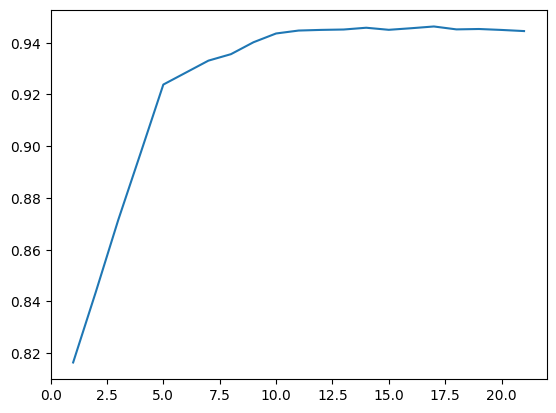

In [19]:
y_points = np.array(list(all_iterations['avg_score']))
x_points = np.array([i for i in range(1, len(y_points) + 1)])

plt.plot(x_points, y_points)